In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from french_stop_words import FRENCH_STOP_WORDS
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df: DataFrame = pd.read_csv("../data/cleaned_dataset.csv")
print(df.head())

                                    cleaned_headline  is_satirical    source
0  Les États-Unis s'engagent à fournir 20 000 dra...             1  legorafi
1  Élisabeth Borne salue le courage du pape Franç...             1  legorafi
2  Donald Trump dévoile les codes de l'arme nuclé...             1  legorafi
3  DAZN offre un abonnement à tous les Français d...             1  legorafi
4                                 Poisson artificiel             1  legorafi


              precision    recall  f1-score   support

           0       0.82      0.85      0.83       996
           1       0.84      0.80      0.82       941

    accuracy                           0.82      1937
   macro avg       0.83      0.82      0.82      1937
weighted avg       0.83      0.82      0.82      1937



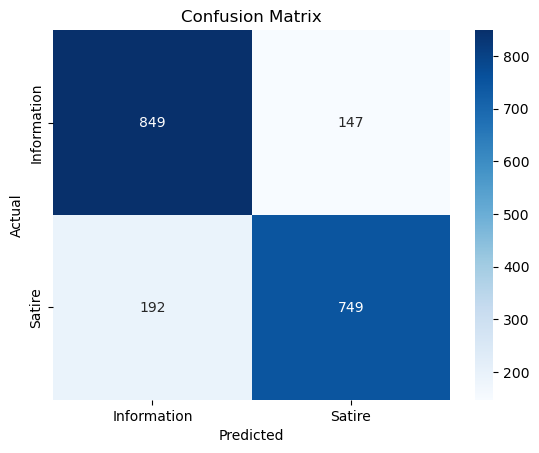

In [3]:
X = df["cleaned_headline"]
y = df["is_satirical"]

# Split train/test
# On utilise stratify pour garder le même ratio 0/1 dans les 2 splits.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Vectorisation TF-IDF car rapide, efficace, et très utilisé pour les séquences textuelles courtes comme ici
# On enlève les stopwords français, et on peut fixer un ngram_range=(1,2)
# pour capturer aussi des expressions fréquentes
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words=FRENCH_STOP_WORDS, ngram_range=(1, 2)
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entraînement du modèle de régression logistique
# Modèle binaire simple, rapide, robuste, et qui fournit une bonne baseline
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Évaluation du modèle
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Information", "Satire"],
    yticklabels=["Information", "Satire"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()